In [124]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, LSTM, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import regularizers


import tensorflow as tf
from tensorflow.keras import layers
import chess
import numpy as np


In [125]:
def fen_to_board(fen):
    # Parse the FEN string
    parts = fen.split(" ")
    board_part = parts[0]
    isWhite = parts[1] == 'w'
    castling_part = parts[2]

    # Convert the board position to a binary matrix
    board = chess.Board(fen)
    binary_board = np.zeros((8, 8, 6), dtype=np.float32)
    piece_amount = np.zeros((12), dtype=np.float32)
    pieces = {'p': [0, 1.0], 'r': [1, 1.0], 'n': [2, 1.0], 'b': [3, 1.0], 'q': [4, 1.0], 'k': [5, 1.0],
              'P': [0, -1.0], 'R': [1, -1.0], 'N': [2, -1.0], 'B': [3, -1.0], 'Q': [4, -1.0], 'K': [5, -1.0]}
    
    for i in range(64):
        piece = board.piece_at(i)
        if piece:
            if isWhite:
                binary_board[i // 8, i % 8, pieces[str(piece)][0]] = pieces[str(piece)][1] 
            else:
                binary_board[7-(i // 8), 7-(i % 8), pieces[str(piece)][0]] = -pieces[str(piece)][1]
            if isWhite ^ (pieces[str(piece)][1] < 0):
                piece_amount[pieces[str(piece)][0]] += 1
            else:
                piece_amount[pieces[str(piece)][0]+6] += 1

    # Add the castling rights to the binary matrix
    # if 'K' in castling_part:
    #     binary_board[..., 6] = 1.0
    # if 'Q' in castling_part:
    #     binary_board[..., 7] = 1.0
    # if 'k' in castling_part:
    #     binary_board[..., 8] = 1.0
    # if 'q' in castling_part:
    #     binary_board[..., 9] = 1.0

    return [binary_board, piece_amount]
    # return binary_board


In [126]:
# model = tf.keras.Sequential([
#     layers.Conv2D(8, (3, 3), activation='relu', padding='same', input_shape=(8, 8, 6)), 
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(16, (3, 3), activation='relu', padding='same'), 
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(32, (3, 3), activation='relu', padding='same'), 
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (2, 2), activation='relu', padding='same'), 
#     # Dropout(0.5),  # Dropout layer
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),  # Increase the number of neurons
#     # Dropout(0.5),  # Dropout layer
#     # layers.Dense(64, activation='relu'),  # Increase the number of neurons
#     # Dropout(0.5),  # Dropout layer
#     layers.Dense(1)
# ])


# model.compile(optimizer='adam',
#               loss=tf.keras.losses.MeanSquaredError(),
#               metrics=['mae'])


main_input = tf.keras.Input(shape=(8, 8, 6), name='main_input')
auxiliary_input = tf.keras.Input(shape=(12), name='auxiliary_input')

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(main_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (2, 2), activation='relu', padding='same')(x)

x = layers.Flatten()(x)
merged_input = layers.concatenate([x, auxiliary_input])

x = layers.Dense(128, activation='relu')(merged_input)
# x = layers.Dropout(0.5)(x)

output = layers.Dense(1)(x)

model = tf.keras.Model(inputs=[main_input, auxiliary_input], outputs=output)

model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mae'])



In [127]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 main_input (InputLayer)     [(None, 8, 8, 6)]            0         []                            
                                                                                                  
 conv2d_42 (Conv2D)          (None, 8, 8, 8)              440       ['main_input[0][0]']          
                                                                                                  
 max_pooling2d_30 (MaxPooli  (None, 4, 4, 8)              0         ['conv2d_42[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_43 (Conv2D)          (None, 4, 4, 16)             1168      ['max_pooling2d_30[0][0]

In [128]:
with open(r'fen_ratingsomate2.txt', 'r') as f:
    lines = f.readlines()

fens = [line.split()[0] + " " + line.split()[1] + " " + line.split()[2] for line in lines]
ratings = [-float(line.split()[-1]) if line.split()[1] == 'b' else float(line.split()[-1]) for line in lines]

# Separate the components into two arrays
binary_boards = []
piece_amounts = []

for fen in fens:
    binary_board, piece_amount = fen_to_board(fen)
    binary_boards.append(binary_board)
    piece_amounts.append(piece_amount)

binary_boards = np.array(binary_boards)
piece_amounts = np.array(piece_amounts)
ratings = np.array(ratings)


In [129]:
train_size = int(len(binary_boards) * 0.7)
val_size = int(len(binary_boards) * 0.15)

# Separate binary boards and piece amounts
x_binary_train, x_piece_train, y_train = binary_boards[:train_size], piece_amounts[:train_size], ratings[:train_size]
x_binary_val, x_piece_val, y_val = binary_boards[train_size:train_size + val_size], piece_amounts[train_size:train_size + val_size], ratings[train_size:train_size + val_size]
x_binary_test, x_piece_test, y_test = binary_boards[train_size + val_size:], piece_amounts[train_size + val_size:], ratings[train_size + val_size:]


In [130]:
history = model.fit([x_binary_train, x_piece_train], y_train, validation_data=([x_binary_val, x_piece_val], y_val), batch_size=32, epochs=10)

Epoch 1/10
3768/3768 [==============================] - 42s 10ms/step - loss: 0.0214 - mae: 0.0822 - val_loss: 0.0226 - val_mae: 0.0853
Epoch 2/10
3768/3768 [==============================] - 34s 9ms/step - loss: 0.0185 - mae: 0.0750 - val_loss: 0.0183 - val_mae: 0.0697
Epoch 3/10
3768/3768 [==============================] - 32s 9ms/step - loss: 0.0174 - mae: 0.0722 - val_loss: 0.0186 - val_mae: 0.0714
Epoch 4/10
3768/3768 [==============================] - 35s 9ms/step - loss: 0.0166 - mae: 0.0703 - val_loss: 0.0182 - val_mae: 0.0690
Epoch 5/10
3768/3768 [==============================] - 34s 9ms/step - loss: 0.0159 - mae: 0.0683 - val_loss: 0.0185 - val_mae: 0.0723
Epoch 6/10
3768/3768 [==============================] - 35s 9ms/step - loss: 0.0156 - mae: 0.0673 - val_loss: 0.0183 - val_mae: 0.0687
Epoch 7/10
3768/3768 [==============================] - 34s 9ms/step - loss: 0.0151 - mae: 0.0658 - val_loss: 0.0186 - val_mae: 0.0714
Epoch 8/10
3768/3768 [==============================] 

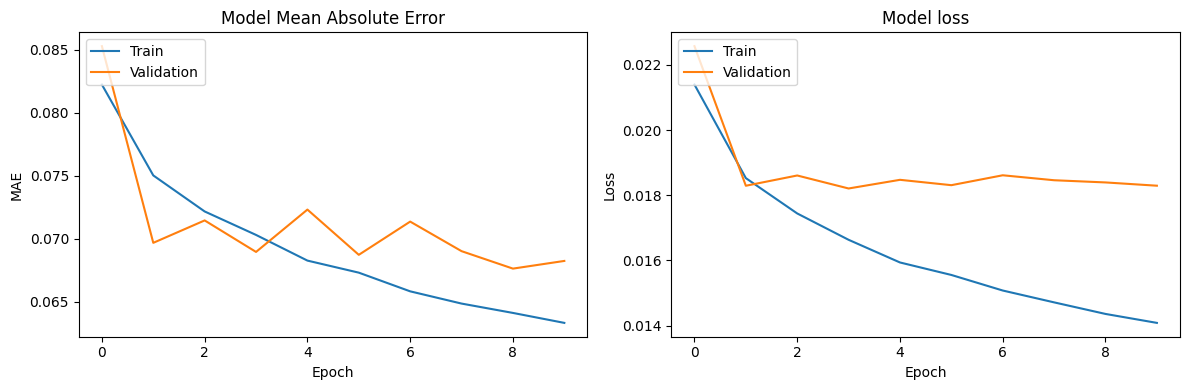

In [131]:
import matplotlib.pyplot as plt

# Plot training & validation MAE values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'])  
plt.plot(history.history['val_mae']) 
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [132]:
model.save('TrainedModel.h5')

c:\Users\21thebes\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


808/808 [==============================] - 4s 5ms/step


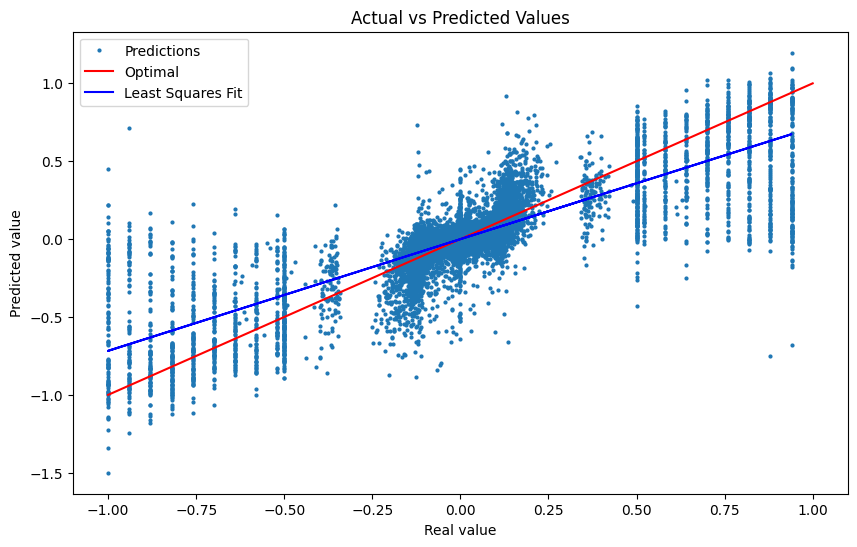

Predicted rating: [0.3617286], True rating: 0.3546003231942781
Predicted rating: [-0.29797903], True rating: -0.11765518506445785


In [134]:
import matplotlib.pyplot as plt
import numpy as np

x_test = [x_binary_test[:30000], x_piece_test[:30000]]
# Predict the ratings for the test data
y_pred = model.predict(x_test)

plt.figure(figsize=(10, 6))

# Scatter plot of actual vs predicted values
plt.plot(y_test, y_pred, marker='o', linestyle='None', markersize=2.0, label='Predictions')

# Line x=y for perfect predictions
plt.plot([-1, 1], [-1, 1], color='red', label='Optimal')

# Least squares fit line
coeff = np.polyfit(y_test.flatten(), y_pred.flatten(), 1)
fit_line = np.polyval(coeff, y_test.flatten())
plt.plot(y_test, fit_line, color='blue', label='Least Squares Fit')

plt.title('Actual vs Predicted Values')
plt.xlabel('Real value')
plt.ylabel('Predicted value')
plt.legend()

plt.show()

# Print the predicted and true ratings for the test data
for i in range(min(len(x_test), 300)):
    print(f"Predicted rating: {y_pred[i]}, True rating: {y_test[i]}")


In [ ]:
import tensorflow as tf
print(tf.__version__)

import tensorflow as tf
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print('No GPU found')



2.15.0
No GPU found
